# 7m data wind analysis

![](https://www.kth.se/polopoly_fs/1.1032323.1606724850!/image/Segelfartygens%20chans%20att%20ta%20revansch%2003_liten.jpg)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [46]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
#pd.set_option('max_colwidth', -1)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from phd.visualization.maps import plot_map, plot_trips
import re
import geopandas
import scipy.integrate
import plotly.express as px
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-grayscale")
plt.rcParams["figure.dpi"] = 300

In [4]:
ships

['M5064-02-A', 'wPCC', '7m']

In [36]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.time_series")
ship_data = catalog.load(f"{ship}.ship_data")
time_series_meta_data = catalog.load(f"{ ship }.time_series_meta_data")
time_series_meta_data['tws'] = (time_series_meta_data['twsBow'] + time_series_meta_data['twsStern'])/2

[05/02/23 14:51:02] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=663237;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=240088;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/02/23 14:51:03] INFO     Kedro project phd                                                      ]8;id=409550;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=232441;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=896684;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=742917;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.time_series' (PartitionedDataSet)...         ]8;id=453725;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=10274;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=152837;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=127718;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.time_series_meta_data' (CSVDataSet)...       ]8;id=754427;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=441520;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [14]:
time_series_meta_data.sort_values(by='date')

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,delta,V,beta,u,v,psi,phi,y_GPS,x_GPS,x0,y0,date
motorZZ_1_thruster_100_Port,4.614160,4.525495,2.486891,12.286663,12.305938,59.292991,18.324195,0.055550,0.697962,3.107473,3.132236,1.710958,0.706300,2.914798,3.133645,1.730714,0.214779,2.486891,0.302276,2.454673,0.661543,4.614160,0.055550,44.475843,315.785062,316.548351,47.173993,2021-04-28 10:26:01.225609984
motorZZ_2_thruster_100_Stb,3.556798,3.646648,2.388526,12.592144,12.538125,59.284942,18.323452,0.061287,0.801782,7.926677,1.237516,5.693845,0.784665,7.708125,1.201041,5.481916,0.218832,2.388526,0.356135,2.388515,0.714152,3.556798,0.061287,22.452942,321.098569,322.718239,24.741893,2021-04-28 10:40:18.614870016
motorZZ_3_thruster_80_Port,6.280696,6.282109,2.262368,12.716622,12.770312,59.287654,18.324165,0.099516,3.119444,2.417766,3.138106,3.484717,3.139754,2.130466,3.140242,3.418727,0.222884,2.262368,7.497672,2.250966,1.980268,6.691098,0.099516,39.969739,314.868037,317.613195,40.023059,2021-04-28 10:48:38.208430080
motorZZ_4_thruster_80_Stb,6.282978,6.278361,2.210224,20.308812,11.145000,59.291236,18.323485,0.058311,3.032030,2.233553,3.141137,3.112513,3.068972,2.232856,3.135590,3.112824,0.194517,2.210224,1.649388,2.207696,2.058192,6.409949,0.058311,75.484327,295.891992,296.675612,78.176643,2021-04-28 10:52:06.805670144
motorZZ_5_thruster_60_Stb,6.282165,6.273283,1.795074,13.440897,13.466875,59.294757,18.321576,0.040460,3.136648,3.013644,3.140824,4.461304,3.140425,3.485960,3.138969,4.821664,0.235041,1.795074,1.515657,1.790822,1.717576,6.425945,0.040460,44.931843,272.685966,274.917855,46.629282,2021-04-28 10:55:51.202689792
motorZZ_6_thruster_60_Port,6.281565,6.275344,1.839285,13.035028,13.002500,59.297606,18.320594,0.052482,3.136805,2.901553,3.140962,4.327306,3.135835,3.393899,3.137505,5.114666,0.226936,1.839285,1.597817,1.833096,1.720829,6.758666,0.052482,30.638473,272.248203,274.928639,30.777402,2021-04-28 10:59:02.200130048
motorZZ_7_thruster_40_Stb,6.282389,6.279349,1.308986,11.263334,11.145000,59.301677,18.319883,0.050605,3.138552,2.697535,3.139877,3.926706,3.138554,2.955966,3.137279,4.237384,0.194517,1.308986,2.032278,1.302223,1.229920,6.345685,0.050605,25.140704,214.983667,217.122696,26.953763,2021-04-28 11:04:18.595930112
motorZZ_8_thruster_40_Port,6.282058,6.280033,1.270748,11.638632,11.609375,59.303793,18.319322,0.038099,3.136076,2.205084,3.137502,2.774606,3.128708,2.022677,3.137482,2.672486,0.202622,1.270748,6.333943,1.249226,1.199217,6.398557,0.038099,15.366148,209.195752,211.984522,15.645311,2021-04-28 11:07:42.593159936
motorZZ_9_thruster_40,3.407302,3.616633,1.059056,11.905680,11.841563,59.302297,18.319604,0.069269,0.651276,6.338551,0.903630,5.421382,0.683296,5.699430,0.946288,4.802026,0.206674,1.059056,0.457297,1.059056,0.424083,3.407302,0.069269,5.476522,189.752303,191.995207,4.885254,2021-04-28 11:14:41.587510016
motorZZ_10_thruster_40,3.814295,3.925403,1.086174,10.027171,9.984063,59.300022,18.319696,0.127323,0.670234,5.673418,0.889456,4.854953,0.734507,5.074579,0.988236,4.272943,0.174255,1.086174,0.587098,1.083376,0.588585,3.814295,0.127323,8.745948,180.474807,182.941952,10.078548,2021-04-28 11:19:14.383780096


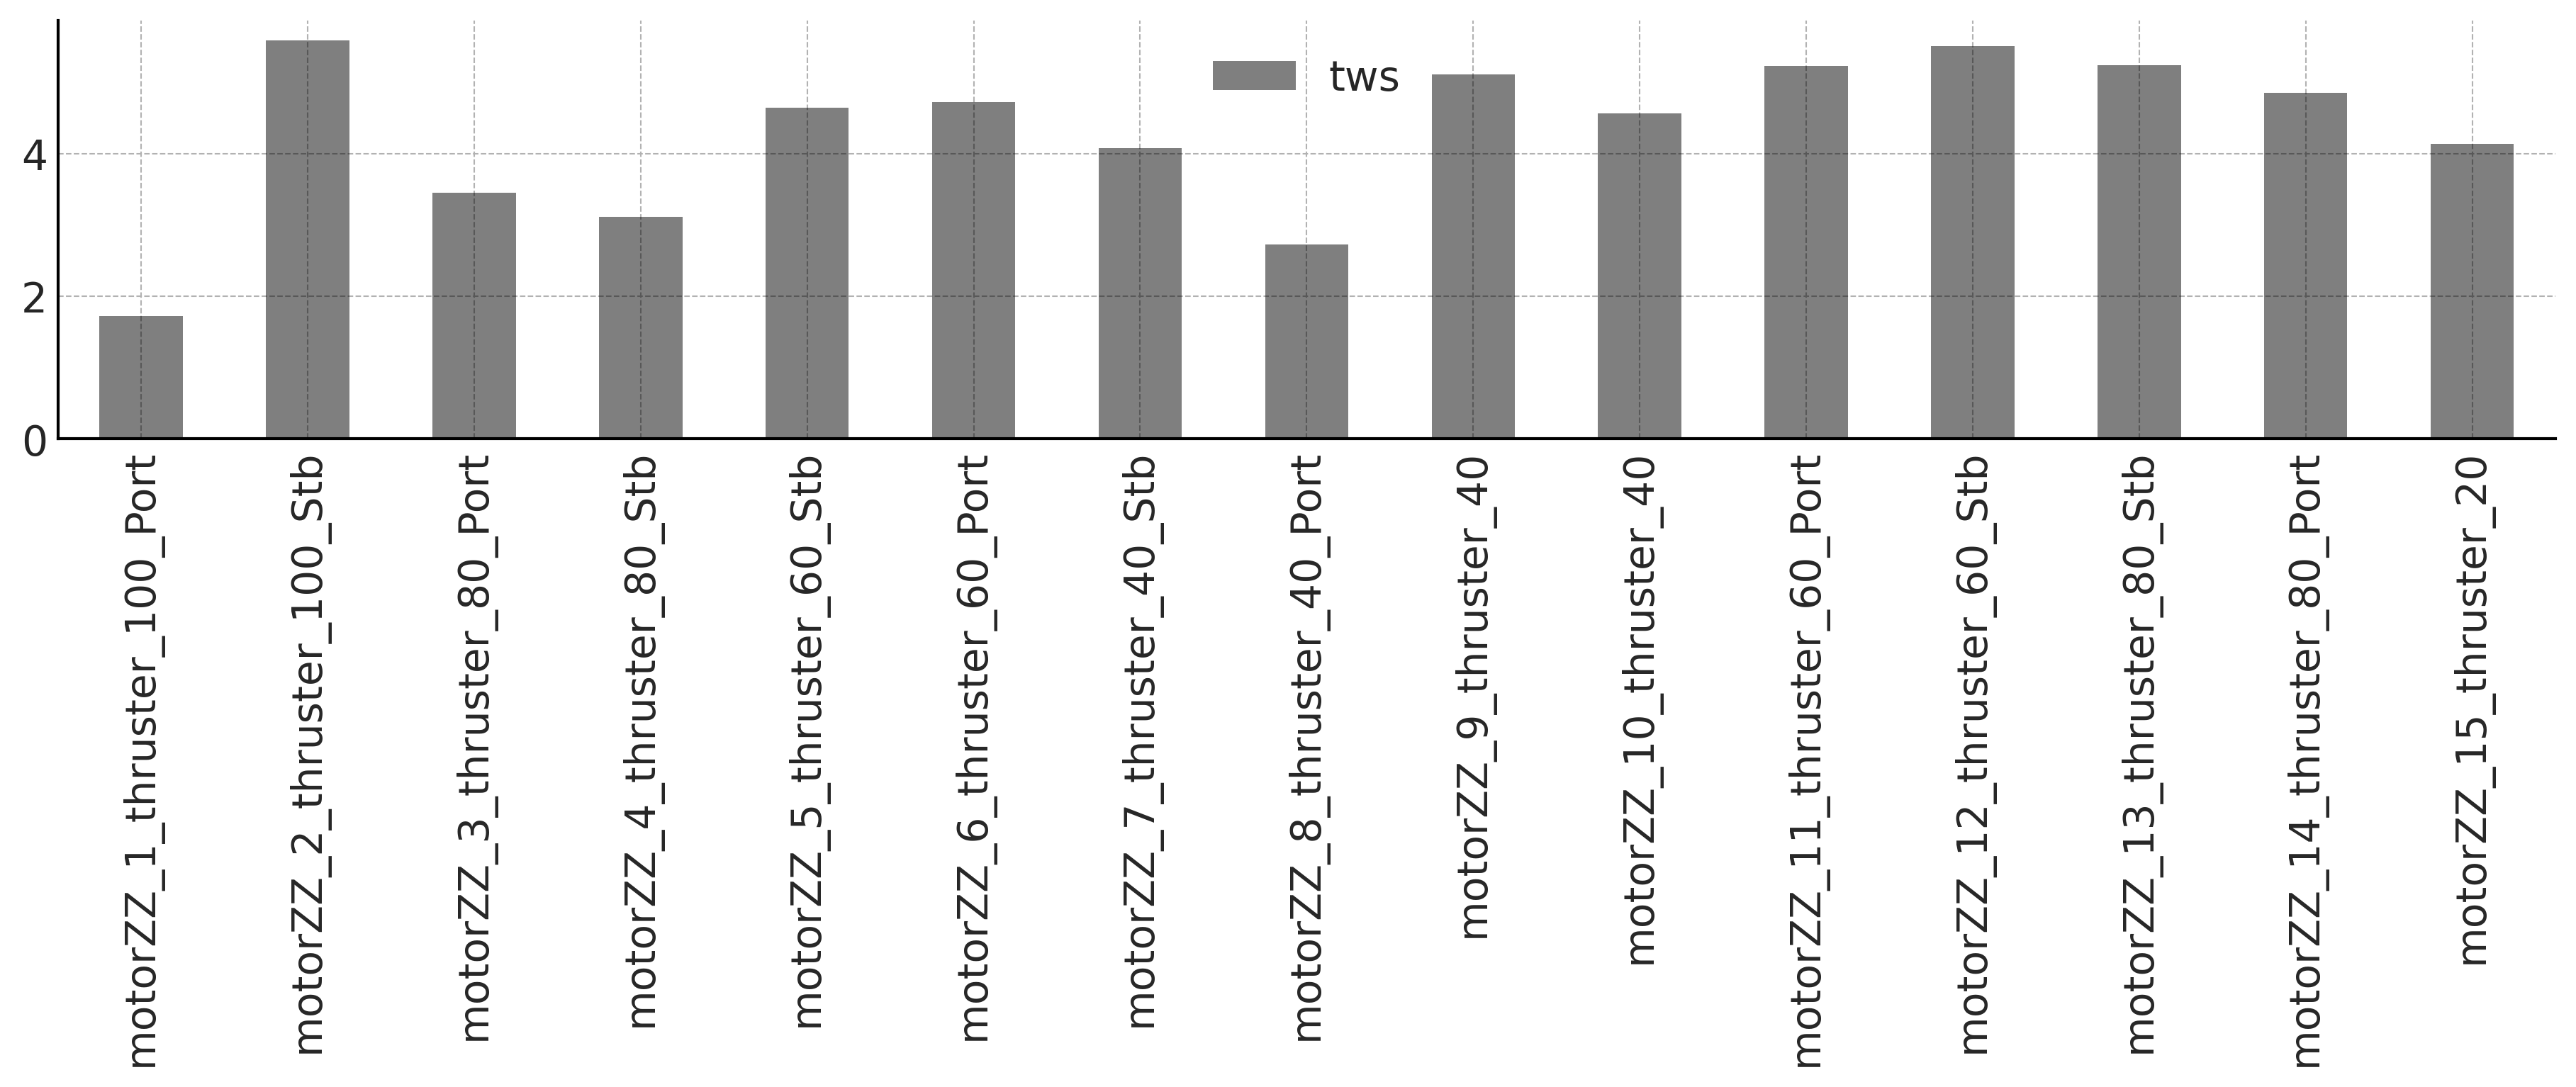

In [57]:
fig,ax=plt.subplots()
fig.set_size_inches(12,5)
time_series_meta_data.sort_values(by='date').plot.bar(y='tws', style='o--', alpha=0.5, ax=ax)
ax.grid()

In [58]:
time_series_meta_data.sort_values(by='date')[['twsBow','twsStern',]]

,twsBow,twsStern
motorZZ_1_thruster_100_Port,1.710958,1.730714
motorZZ_2_thruster_100_Stb,5.693845,5.481916
motorZZ_3_thruster_80_Port,3.484717,3.418727
motorZZ_4_thruster_80_Stb,3.112513,3.112824
motorZZ_5_thruster_60_Stb,4.461304,4.821664
motorZZ_6_thruster_60_Port,4.327306,5.114666
motorZZ_7_thruster_40_Stb,3.926706,4.237384
motorZZ_8_thruster_40_Port,2.774606,2.672486
motorZZ_9_thruster_40,5.421382,4.802026
motorZZ_10_thruster_40,4.854953,4.272943


In [59]:
id = "motorZZ_1_thruster_100_Port"
data = time_series[id]()

5.013342833243968

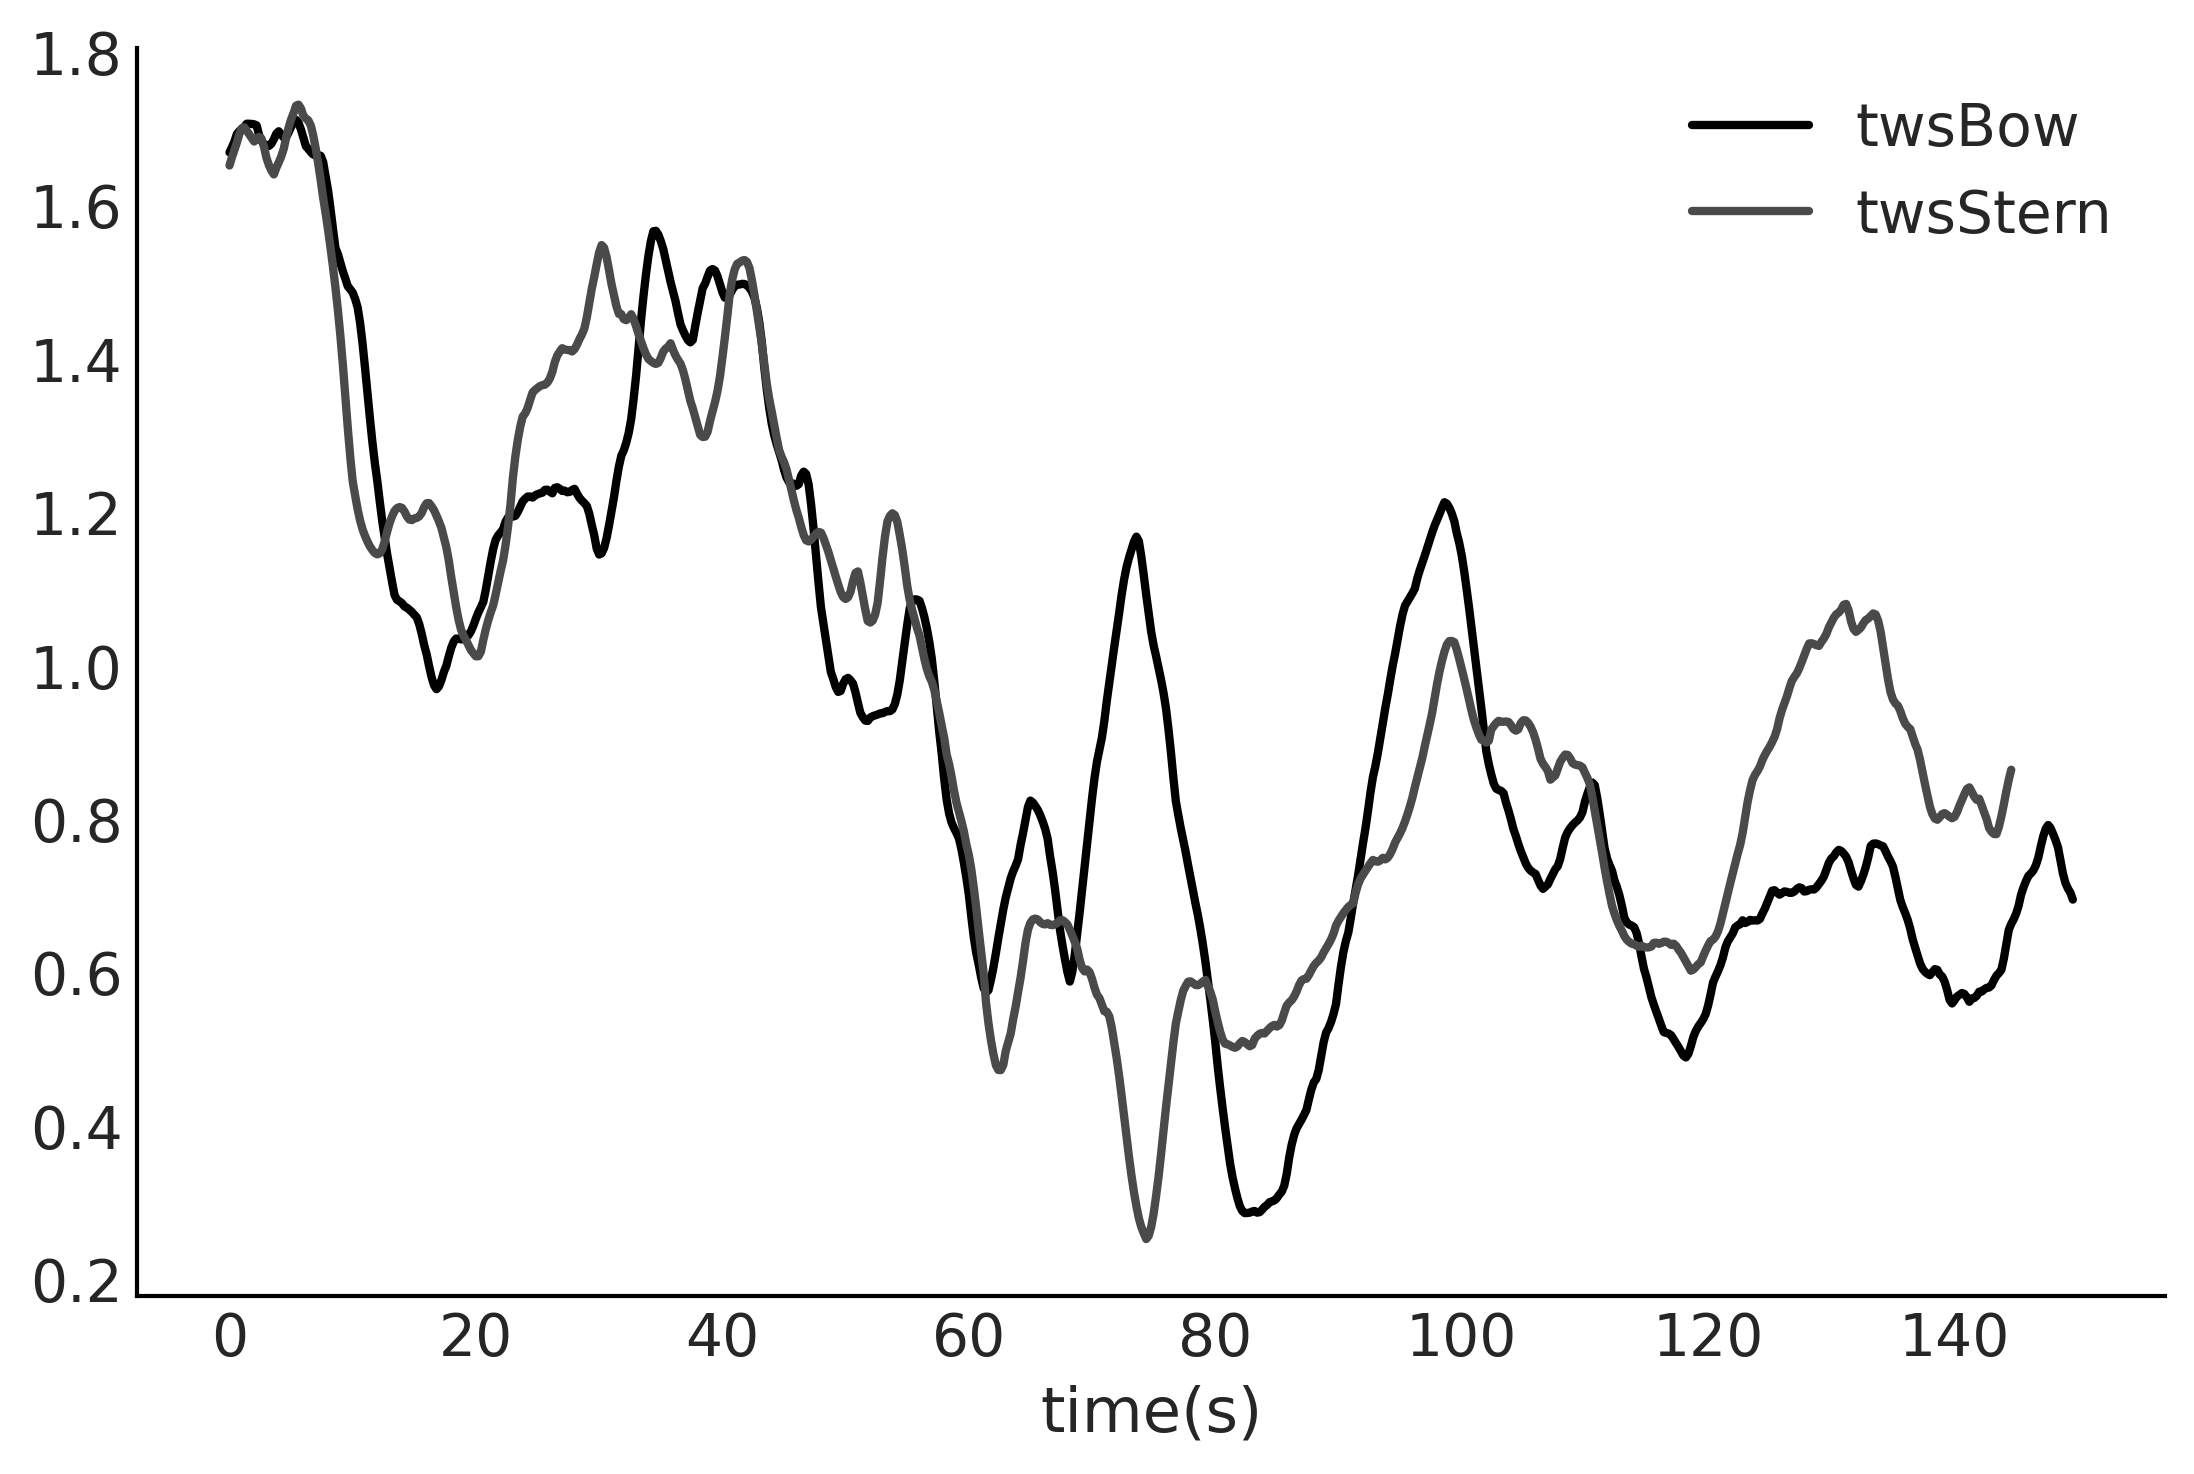

In [60]:
data_ = data.copy()
data_['twsStern']=data.shift(-25)['twsStern']
data_.plot(y=['twsBow','twsStern',])
np.mean(np.diff(data_.index))*25

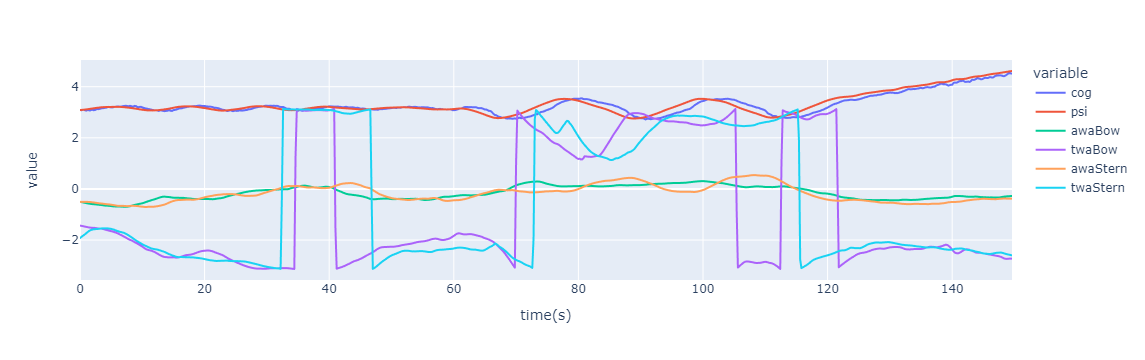

In [62]:
columns = [
'cog',
'psi',
'awaBow',
'twaBow',	
'awaStern',	
'twaStern',	
]
px.line(data,y=columns)


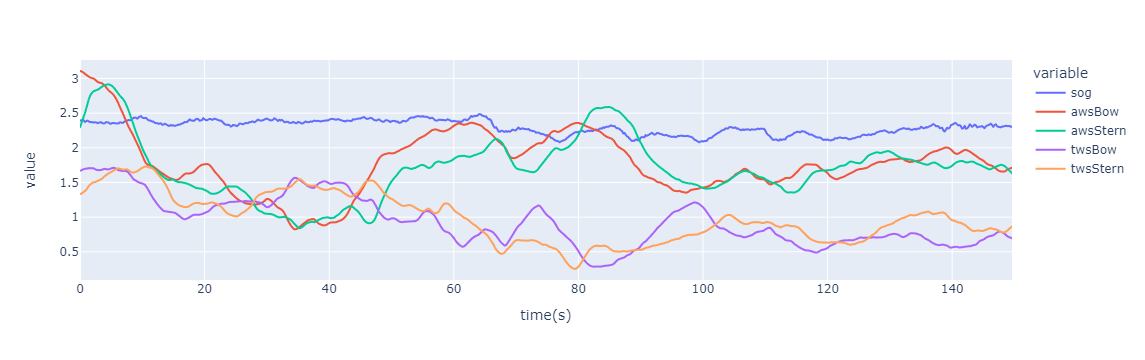

In [63]:
columns = [
'sog',
'awsBow',
'awsStern',	
'twsBow',
'twsStern',
]
px.line(data,y=columns)